#Import Libraries

In [0]:
%tensorflow_version 2.x

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pathlib

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.layers import MaxPool2D, MaxPool1D
from tensorflow.keras.layers import Dropout, BatchNormalization

from google.colab import drive

print("Module Loaded.")
print("TensorFlow Version :{}".format(tf.__version__))
print("NumPy Version :{}".format(np.__version__))
print("Matplotlib Version :{}".format(plt.matplotlib.__version__))

Module Loaded.
TensorFlow Version :2.1.0-rc1
NumPy Version :1.17.4
Matplotlib Version :3.1.2


In [0]:
drive.mount('/content/drive')

data_path = pathlib.Path('/content/drive/Shared drives/scsa_2019_b/Project_Ai-KEA/data_resize/furniture')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
class_name = np.array([item.name for item in data_path.glob('*')])
print(class_name)

['bookshelves' 'fireplace' 'floor lamp' 'chair' 'entertainment center'
 'dressing table' 'bed' 'curtain' 'sofa' 'table']


# Load Function

In [0]:
def plot_loss():

    loss = history.history['loss']
    epochs = range(1, len(loss)+1)

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 1, 1)
    plt.title('Validation Loss & Training Loss')
    plt.semilogy(epochs, history.history['val_loss'], 'b', label='CNN')
    plt.semilogy(epochs, history.history['loss'], 'b', label='CNN')
    plt.grid(True)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    #plt.ylim([0.0, 0.6])
    plt.legend(loc='best')

    plt.show()

def plot_acc():

    loss = history.history['loss']
    epochs = range(1, len(loss)+1)

    plt.figure(figsize=(10, 10))
    plt.subplot(1,1,1)
    plt.title('Validation Accuray & Training Accuracy')
    plt.semilogy(epochs, history.history['val_accuracy'], 'b', label='CNN')
    plt.semilogy(epochs, history.history['accuracy'], 'b', label='CNN')
    plt.grid(True)
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1.0])
    plt.legend(loc='best')
    plt.show()

In [0]:
def generate_data(data_path, img_size=224, batch_n=180):

    image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
                                #width_shift_range=0.2,
                                #height_shift_range=0.2,
                                #horizontal_flip=True, 
                                #vertical_flip=True,
                                #rotation_range=30,
                                zoom_range=0.1,
                                brightness_range=[0.8,1.2],
                                validation_split=0.2,
                                rescale=1./255)
    
    train_data_generate = image_generator.flow_from_directory(
        
                                directory=str(data_path),
                                batch_size=batch_n,
                                shuffle=True,
                                target_size=(img_size, img_size),
                                classes = list(class_name),
                                subset='training')
    
    test_data_generate = image_generator.flow_from_directory(
                                directory=str(data_path),
                                batch_size=batch_n,
                                shuffle=True,
                                target_size=(img_size, img_size),
                                classes = list(class_name),
                                subset='validation')
    
    return train_data_generate, test_data_generate


# Prepare Data

- **Unzip Data**

In [0]:
import os

cwd = os.getcwd()
print(cwd)

!unzip /content/drive/Shared\ drives/scsa_2019_b/Project_Ai-KEA/data_resize/furniture.zip -d /content/furniture

/content
Archive:  /content/drive/Shared drives/scsa_2019_b/Project_Ai-KEA/data_resize/furniture.zip
replace /content/furniture/bed/bed (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/furniture/bed/bed (1).jpg  
  inflating: /content/furniture/bed/bed (10).jpg  
  inflating: /content/furniture/bed/bed (100).jpg  
  inflating: /content/furniture/bed/bed (1000).jpg  
  inflating: /content/furniture/bed/bed (1001).jpg  
  inflating: /content/furniture/bed/bed (1002).jpg  
  inflating: /content/furniture/bed/bed (1003).jpg  
  inflating: /content/furniture/bed/bed (1004).jpg  
  inflating: /content/furniture/bed/bed (1005).jpg  
  inflating: /content/furniture/bed/bed (1006).jpg  
  inflating: /content/furniture/bed/bed (1007).jpg  
  inflating: /content/furniture/bed/bed (1008).jpg  
  inflating: /content/furniture/bed/bed (1009).jpg  
  inflating: /content/furniture/bed/bed (101).jpg  
  inflating: /content/furniture/bed/bed (1010).jpg  
  inflating: /content/furni

In [0]:
data_path = pathlib.Path('/content/furniture')
class_name = np.array([item.name for item in data_path.glob('*')])
print(class_name)

['bookshelves' 'dressing table' 'bed' 'chair' 'sofa' 'fireplace'
 'entertainment center' 'table' 'curtain' 'floor lamp']


#ImageGenerator

In [0]:
img_size =  224
batch_n = 180

data_path = pathlib.Path('/content/furniture')
train_data_generate, test_data_generate = generate_data(data_path, img_size, batch_n)

Found 12559 images belonging to 10 classes.
Found 3135 images belonging to 10 classes.


#Load Inception

import model

In [0]:
import tensorflow.keras.applications.inception_v3 as incep

model_incep = incep.InceptionV3(
    weights="imagenet", 
    #include_top=False,    # dense layer 이 후는 제외
    input_tensor=tf.keras.layers.Input(shape=(img_size, img_size, 3))
    #input_tensor=keras.layers.Input(shape=(49, 49, 3))
)

model_incep.summary()

96116736/96112376 [==============================] - 4s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________

##fine tuning

In [0]:
epoch_n = 100

make ai-kea model

In [0]:
#inputs = model_incep.inputs
#print(inputs[0])
inputs = model_incep.get_layer('mixed7').output
x = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', name='conv_feat')(inputs) 
x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', name='conv_fddea')(x) 
x = tf.keras.layers.BatchNormalization(momentum=0.85)(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x) 

aikea_model = tf.keras.Model(inputs=model_incep.inputs, outputs=outputs, name='grad_model')

aikea_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

aikea_model.summary()

Model: "grad_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_________________________________________________________________________________________

In [0]:
aikea_model.fit_generator(
    train_data_generate,
    epochs = epoch_n,
    validation_data = test_data_generate
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 70 steps, validate for 18 steps
Epoch 1/100
 3/70 [>.............................] - ETA: 9:42 - loss: 3.2759 - accuracy: 0.1583 

KeyboardInterrupt: ignored

In [0]:
grad_model = tf.keras.models.Model(
    [model_incep.inputs],                           # input: vgg16 inputs
    [aikea_model.get_layer('conv_fddea').output,  # outputs: vgg16 last conv
     aikea_model.output]                           # softmax out
)
print(grad_model)

In [0]:
plot_loss()

In [0]:
plot_acc()

In [0]:
save_path = '/content/drive/Shared drives/scsa_2019_b/Project_Ai-KEA/code/model_checkpoint/'


# Load Prev Model

In [0]:
def load_models(date, epoch, model_name, num):
  model = tf.keras.models.load_model(save_path+"aikea_{}_{}_{}_{}.hdf5".format(date, epoch, model_name, num))
  return model

In [0]:
prev_ai_kea = load_models("day2", 20, "GoogLeNet", "00-1")

In [0]:
prev_ai_kea.summary()

prev_ai_kea.get_layer('mixed7').output

Model: "grad_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_________________________________________________________________________________________

<tf.Tensor 'mixed7_1/Identity:0' shape=(None, 12, 12, 768) dtype=float32>

# Training

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint as mcp

epoch_n = 5
img_size = 224
batch_n = 150
data_path = pathlib.Path('/content/furniture')

train_data_generate, test_data_generate = generate_data(data_path, img_size, batch_n)

checkpoint = mcp('/content/drive/Shared drives/scsa_2019_b/Project_Ai-KEA/code/model_checkpoint/googlenet_master_012_lsy2.h5',
                 monitor="val_accuracy", mode="max",
                 save_best_only=True)

history = prev_ai_kea.fit_generator(
                train_data_generate,
                epochs = epoch_n,
                validation_data = test_data_generate,
                callbacks=[checkpoint,])

Found 12559 images belonging to 10 classes.
Found 3135 images belonging to 10 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 84 steps, validate for 21 steps
Epoch 1/5
84/84 [==============================] - 227s 3s/step - loss: 0.6135 - accuracy: 0.8322 - val_loss: 24.0542 - val_accuracy: 0.6415
Epoch 2/5
84/84 [==============================] - 227s 3s/step - loss: 0.2517 - accuracy: 0.9192 - val_loss: 0.8498 - val_accuracy: 0.7735
Epoch 3/5
84/84 [==============================] - 228s 3s/step - loss: 0.1316 - accuracy: 0.9580 - val_loss: 0.7410 - val_accuracy: 0.8086
Epoch 4/5
84/84 [==============================] - 227s 3s/step - loss: 0.0655 - accuracy: 0.9792 - val_loss: 0.9801 - val_accuracy: 0.8112
Epoch 5/5
84/84 [==============================] - 226s 3s/step - loss: 0.0457 - accuracy: 0.9861 - val_loss: 0.9620 - val_accuracy: 0.8156


In [0]:
# aikea_day2_20_GoogLeNet_00
def save_model(date, epoch, model_name, num):
    prev_ai_kea.save(save_path+"aikea_{}_{}_{}_{}.hdf5".format(date, epoch, model_name, num))

save_model("day2", 20, "GoogLeNet", "00-1")

# PLOT LEARNING

In [0]:
print(np.max(history.history['val_accuracy']))

0.81562996


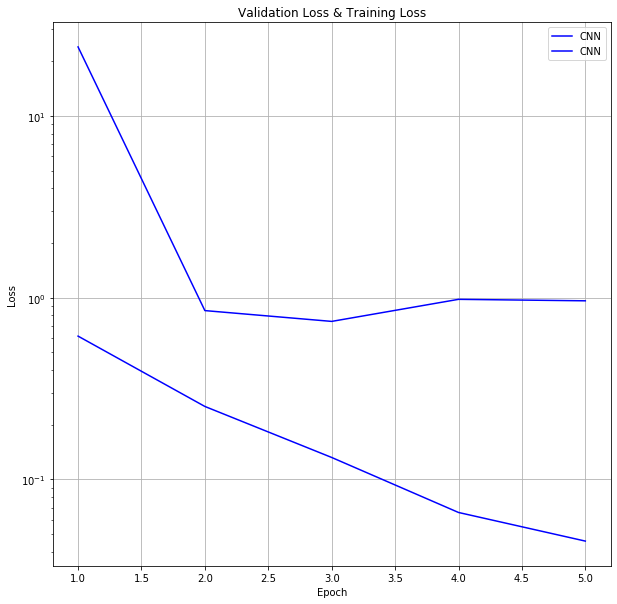

In [0]:
plot_loss()

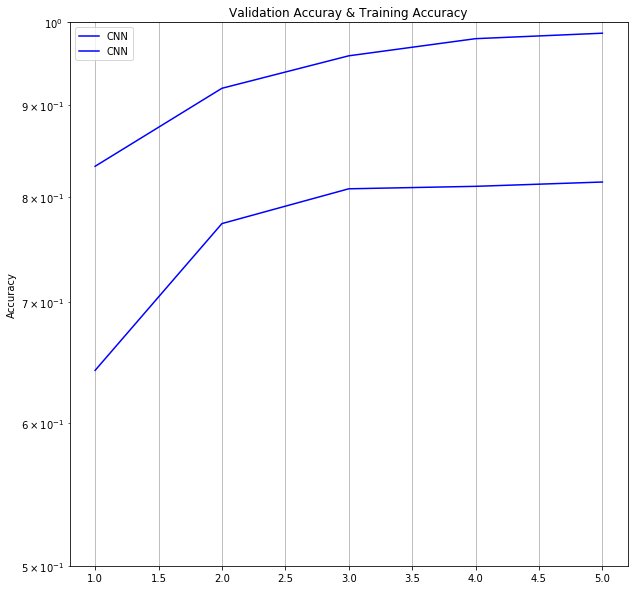

In [0]:
plot_acc()

# CAM

In [0]:
import cv2
import matplotlib.patches as patches
from keras.applications.vgg16 import decode_predictions
from tensorflow.keras.preprocessing import image
import tensorflow.keras.applications.inception_v3 as incep

def buildCAM(img_path, img_alpha, heatmap_alpha, aikea_model=prev_ai_kea): # 0<= alpha <=1

    # load the image with the required shape
    img = image.load_img(img_path, target_size=(img_size, img_size))
    # check image
    plt.imshow(img)
    # convert the image to an array
    img = image.img_to_array(img)         # tf.keras.processing
    # expand dimensions so that it represents a single 'sample'
    img = np.expand_dims(img, axis=0)     # numpy
    # prepare the image (e.g. scale pixel values for the vgg)
    img = incep.preprocess_input(img)     # VGG16.preprocess_input

    grad_model = tf.keras.models.Model(
        [aikea_model.inputs],                           # input: vgg16 inputs
        [aikea_model.get_layer('conv_feat').output,  # outputs: vgg16 last conv
        aikea_model.output]                           # softmax out
    )

    # GradientTape 설정
    with tf.GradientTape() as tape:
        conv_outputs, predict = grad_model(img)   # feature, predict
        class_out = predict[:, np.argmax(predict[0])]    # class     
    print(predict[0])

    # feature map
    output = conv_outputs[0]

    # Get gradient for input image
    grads = tape.gradient(class_out, conv_outputs)[0]

    # check grads' shape
    print('grads', grads.shape, output.shape)

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=(0, 1))

    
    # Build a map of filters according to gradients importance
    cam = np.ones(output.shape[0:2], dtype=np.float32)

    for index, w in enumerate(weights):
        print(w)
        cam += w * output[:, :, index]

    # check cam shape
    print('cam', cam.shape, weights.shape)
    print(cam)


    # image read: ndarray type
    img = cv2.imread(img_path)
    # GBR -> RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # cv2는 기본적으로 image를 GBR로 처리

    plt.imshow(img)

    print('img', img.shape, type(img))


    # resize cam
    cam = cv2.resize(cam.numpy(), (img.shape[1], img.shape[0]))
    cam = np.maximum(cam, 0)          # 0 이상의 값만 취함
    # heatmap : minmax normalized one
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())

    # convert heatmap to rgb
    heatmap = np.uint8(255 * heatmap)                       # RGB range (0~255)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # apply color map
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)      # colormap to RGB
    
    # get heatmap outline
    heatlist = heatmap.tolist()
    t_pos = []
    for i in range(len(heatlist)):
      for j in range(len(heatlist[i])):
        if heatlist[i][j][2]<200: t_pos.append((i, j))

    y_max = max([i[0] for i in t_pos])
    y_min = min([i[0] for i in t_pos])
    x_max = max([i[1] for i in t_pos])
    x_min = min([i[1] for i in t_pos])

    # check heatmap shape
    plt.imshow(heatmap)
    heatmap.shape #(426, 640, 3)

    # blending heatmap: image: 100%, heatmap: 50%
    output_image = cv2.addWeighted(img.astype('uint8'), img_alpha,  # 1: 100%
                                  heatmap, heatmap_alpha,            # 0.5: 50%
                                  0)
    
    
    return predict[0], output_image, y_min, x_min, (y_max-y_min), (x_max-x_min)

Using TensorFlow backend.


In [0]:
img_path = '/content/furniture/chair/chair (113).jpg'

#접기

tf.Tensor(
[1.2782555e-06 2.7522565e-06 9.9222653e-04 9.9895597e-01 4.6235364e-06
 1.9716836e-06 7.5762307e-07 3.4421733e-05 6.1798073e-07 5.3606091e-06], shape=(10,), dtype=float32)
grads (12, 12, 256) (12, 12, 256)
tf.Tensor(-1.2521343e-08, shape=(), dtype=float32)
tf.Tensor(-3.956169e-07, shape=(), dtype=float32)
tf.Tensor(2.9429665e-07, shape=(), dtype=float32)
tf.Tensor(-9.923794e-08, shape=(), dtype=float32)
tf.Tensor(4.887051e-07, shape=(), dtype=float32)
tf.Tensor(-3.783199e-07, shape=(), dtype=float32)
tf.Tensor(-1.9648814e-07, shape=(), dtype=float32)
tf.Tensor(4.884189e-07, shape=(), dtype=float32)
tf.Tensor(-3.1460402e-08, shape=(), dtype=float32)
tf.Tensor(-8.726955e-07, shape=(), dtype=float32)
tf.Tensor(4.2574007e-07, shape=(), dtype=float32)
tf.Tensor(1.2016845e-09, shape=(), dtype=float32)
tf.Tensor(-1.262778e-06, shape=(), dtype=float32)
tf.Tensor(4.2276636e-07, shape=(), dtype=float32)
tf.Tensor(-1.7446074e-07, shape=(), dtype=float32)
tf.Tensor(8.038121e-08, shape=(

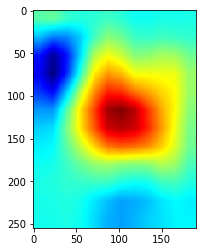

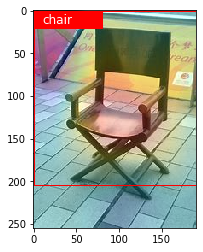

In [0]:
import cv2
import matplotlib.patches as patches
from tensorflow.keras.preprocessing import image

# define Model
pred_list=[]
pred_list, output_image, yy, xx, h, w = buildCAM(img_path, 1, 0.2)
pred_cls = class_name[np.argmax(pred_list)]
print(pred_cls)
fig, ax = plt.subplots(1)
rect = patches.Rectangle((xx, yy), w, h, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

rect_txt = patches.Rectangle((xx,yy), 80, 20, edgecolor='r', facecolor='r')
ax.add_patch(rect)
ax.add_patch(rect_txt)
ax.text(xx+10, yy+15, 
         '{}'.format(pred_cls),
         fontsize=12, color='w')
ax.imshow(output_image)

In [0]:
imag_path = '/content/furniture/chair/chair (113).jpg'
img_alpha = 1
heatmap_alpha = 0.2
aikea_model = prev_ai_kea

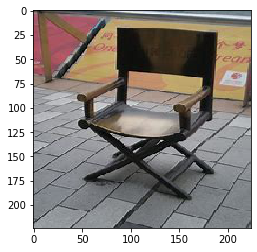

In [0]:
# load the image with the required shape
img = image.load_img(img_path, target_size=(img_size, img_size))
# check image
plt.imshow(img)
# convert the image to an array
img = image.img_to_array(img)         # tf.keras.processing
# expand dimensions so that it represents a single 'sample'
img = np.expand_dims(img, axis=0)     # numpy
# prepare the image (e.g. scale pixel values for the vgg)
img = incep.preprocess_input(img)     # VGG16.preprocess_input

grad_model = tf.keras.models.Model(
    [aikea_model.inputs],                           # input: vgg16 inputs
    [aikea_model.get_layer('conv_feat').output,  # outputs: vgg16 last conv
    aikea_model.output]                           # softmax out
)



tf.Tensor(
[1.2782555e-06 2.7522565e-06 9.9222653e-04 9.9895597e-01 4.6235364e-06
 1.9716836e-06 7.5762307e-07 3.4421733e-05 6.1798073e-07 5.3606091e-06], shape=(10,), dtype=float32)
grads (12, 12, 256) (12, 12, 256)
tf.Tensor(-1.2521343e-08, shape=(), dtype=float32)
tf.Tensor(-3.956169e-07, shape=(), dtype=float32)
tf.Tensor(2.9429665e-07, shape=(), dtype=float32)
tf.Tensor(-9.923794e-08, shape=(), dtype=float32)
tf.Tensor(4.887051e-07, shape=(), dtype=float32)
tf.Tensor(-3.783199e-07, shape=(), dtype=float32)
tf.Tensor(-1.9648814e-07, shape=(), dtype=float32)
tf.Tensor(4.884189e-07, shape=(), dtype=float32)
tf.Tensor(-3.1460402e-08, shape=(), dtype=float32)
tf.Tensor(-8.726955e-07, shape=(), dtype=float32)
tf.Tensor(4.2574007e-07, shape=(), dtype=float32)
tf.Tensor(1.2016845e-09, shape=(), dtype=float32)
tf.Tensor(-1.262778e-06, shape=(), dtype=float32)
tf.Tensor(4.2276636e-07, shape=(), dtype=float32)
tf.Tensor(-1.7446074e-07, shape=(), dtype=float32)
tf.Tensor(8.038121e-08, shape=(

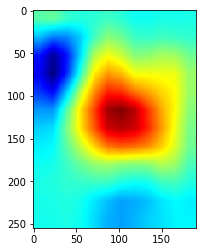

In [0]:
# GradientTape 설정
with tf.GradientTape() as tape:
    conv_outputs, predict = grad_model(img)   # feature, predict
    class_out = predict[:, np.argmax(predict[0])]    # class     
print(predict[0])

# feature map
output = conv_outputs[0]

# Get gradient for input image
grads = tape.gradient(class_out, conv_outputs)[0]

# check grads' shape
print('grads', grads.shape, output.shape)

# Average gradients spatially
weights = tf.reduce_mean(grads, axis=(0, 1))


# Build a map of filters according to gradients importance
cam = np.ones(output.shape[0:2], dtype=np.float32)

for index, w in enumerate(weights):
    print(w)
    cam += w * output[:, :, index]

# check cam shape
print('cam', cam.shape, weights.shape)
print(cam)


# image read: ndarray type
img = cv2.imread(img_path)
# GBR -> RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # cv2는 기본적으로 image를 GBR로 처리

plt.imshow(img)

print('img', img.shape, type(img))


# resize cam
cam = cv2.resize(cam.numpy(), (img.shape[1], img.shape[0]))
cam = np.maximum(cam, 0)          # 0 이상의 값만 취함
# heatmap : minmax normalized one
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

# convert heatmap to rgb
heatmap = np.uint8(255 * heatmap)                       # RGB range (0~255)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # apply color map
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)      # colormap to RGB

# get heatmap outline
heatlist = heatmap.tolist()
t_pos = []
for i in range(len(heatlist)):
  for j in range(len(heatlist[i])):
    if heatlist[i][j][2]<200: t_pos.append((i, j))

# check heatmap shape
plt.imshow(heatmap)
heatmap.shape #(426, 640, 3)

# blending heatmap: image: 100%, heatmap: 50%
output_image = cv2.addWeighted(img.astype('uint8'), img_alpha,  # 1: 100%
                              heatmap, heatmap_alpha,            # 0.5: 50%
                              0)


tf.Tensor(
[1.2782555e-06 2.7522565e-06 9.9222653e-04 9.9895597e-01 4.6235364e-06
 1.9716836e-06 7.5762307e-07 3.4421733e-05 6.1798073e-07 5.3606091e-06], shape=(10,), dtype=float32)
grads (12, 12, 256) (12, 12, 256)
tf.Tensor(1.3524134e-08, shape=(), dtype=float32)
tf.Tensor(3.9682936e-07, shape=(), dtype=float32)
tf.Tensor(-2.8372065e-07, shape=(), dtype=float32)
tf.Tensor(9.8309414e-08, shape=(), dtype=float32)
tf.Tensor(-4.6697375e-07, shape=(), dtype=float32)
tf.Tensor(3.4491805e-07, shape=(), dtype=float32)
tf.Tensor(1.8143042e-07, shape=(), dtype=float32)
tf.Tensor(-4.4556953e-07, shape=(), dtype=float32)
tf.Tensor(2.620936e-08, shape=(), dtype=float32)
tf.Tensor(8.6536824e-07, shape=(), dtype=float32)
tf.Tensor(-4.137003e-07, shape=(), dtype=float32)
tf.Tensor(-3.019641e-10, shape=(), dtype=float32)
tf.Tensor(1.2579369e-06, shape=(), dtype=float32)
tf.Tensor(-4.3621296e-07, shape=(), dtype=float32)
tf.Tensor(1.6319837e-07, shape=(), dtype=float32)
tf.Tensor(-9.210295e-08, shape

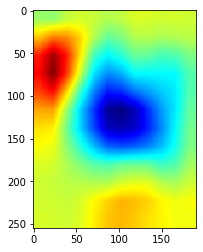

In [0]:
# GradientTape 설정
with tf.GradientTape() as tape:
    conv_outputs, predict = grad_model(img)   # feature, predict
    class_out = predict[:, np.argsort(predict[0])[-2]]    # class     
print(predict[0])

# feature map
output = conv_outputs[0]

# Get gradient for input image
grads = tape.gradient(class_out, conv_outputs)[0]

# check grads' shape
print('grads', grads.shape, output.shape)

# Average gradients spatially
weights = tf.reduce_mean(grads, axis=(0, 1))


# Build a map of filters according to gradients importance
cam = np.ones(output.shape[0:2], dtype=np.float32)

for index, w in enumerate(weights):
    print(w)
    cam += w * output[:, :, index]

# check cam shape
print('cam', cam.shape, weights.shape)
print(cam)


# image read: ndarray type
img = cv2.imread(img_path)
# GBR -> RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # cv2는 기본적으로 image를 GBR로 처리

plt.imshow(img)

print('img', img.shape, type(img))


# resize cam
cam = cv2.resize(cam.numpy(), (img.shape[1], img.shape[0]))
cam = np.maximum(cam, 0)          # 0 이상의 값만 취함
# heatmap : minmax normalized one
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

# convert heatmap to rgb
heatmap = np.uint8(255 * heatmap)                       # RGB range (0~255)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # apply color map
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)      # colormap to RGB

# get heatmap outline
heatlist = heatmap.tolist()
t_pos = []
for i in range(len(heatlist)):
  for j in range(len(heatlist[i])):
    if heatlist[i][j][2]<200: t_pos.append((i, j))

# check heatmap shape
plt.imshow(heatmap)
heatmap.shape #(426, 640, 3)

# blending heatmap: image: 100%, heatmap: 50%
output_image = cv2.addWeighted(img.astype('uint8'), img_alpha,  # 1: 100%
                              heatmap, heatmap_alpha,            # 0.5: 50%
                              0)


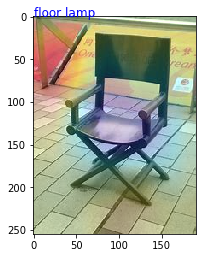

In [0]:
#pred_list=[]
#pred_list, output_image, output_image2 = buildCAM_multi(img_path, 1, 0.2)
pred_cls = class_name[np.argsort(predict[0])[-2]]
#print(pred_cls)
fig, ax = plt.subplots(1)
#rect = patches.Rectangle((xx, yy), w, h, linewidth=1, edgecolor='r', facecolor='none')
#ax.add_patch(rect)

# rect_txt = patches.Rectangle((xx,yy), 80, 20, edgecolor='r', facecolor='r')
# ax.add_patch(rect)
# ax.add_patch(rect_txt)
ax.text(0, 0, '{}'.format(pred_cls), fontsize=12, color='b')
ax.imshow(output_image)

#접기

In [0]:
def buildCAM_mul(index, img_path, img_alpha, heatmap_alpha, aikea_model=prev_ai_kea): # 0<= alpha <=1
    
    ##idx 
    idx = -index
    # load the image with the required shape
    img = image.load_img(img_path, target_size=(img_size, img_size))
    # check image
    plt.imshow(img)
    # convert the image to an array
    img = image.img_to_array(img)         # tf.keras.processing
    # expand dimensions so that it represents a single 'sample'
    img = np.expand_dims(img, axis=0)     # numpy
    # prepare the image (e.g. scale pixel values for the vgg)
    img = incep.preprocess_input(img)     # VGG16.preprocess_input

    grad_model = tf.keras.models.Model(
        [aikea_model.inputs],                           # input: vgg16 inputs
        [aikea_model.get_layer('conv_feat').output,  # outputs: vgg16 last conv
        aikea_model.output]                           # softmax out
    )

    # GradientTape 설정
    with tf.GradientTape() as tape:
        conv_outputs, predict = grad_model(img)   # feature, predict
        class_out = predict[:, np.argsort(predict[0])[idx]]    # class     
    print(predict[0])

    # feature map
    output = conv_outputs[0]

    # Get gradient for input image
    grads = tape.gradient(class_out, conv_outputs)[0]

    # check grads' shape
    print('grads', grads.shape, output.shape)

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=(0, 1))

    
    # Build a map of filters according to gradients importance
    cam = np.ones(output.shape[0:2], dtype=np.float32)

    for index, w in enumerate(weights):
        print(w)
        cam += w * output[:, :, index]

    # check cam shape
    #print('cam', cam.shape, weights.shape)
    #print(cam)


    # image read: ndarray type
    img = cv2.imread(img_path)
    # GBR -> RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # cv2는 기본적으로 image를 GBR로 처리

    plt.imshow(img)

    #print('img', img.shape, type(img))


    # resize cam
    cam = cv2.resize(cam.numpy(), (img.shape[1], img.shape[0]))
    cam = np.maximum(cam, 0)          # 0 이상의 값만 취함
    # heatmap : minmax normalized one
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())

    # convert heatmap to rgb
    heatmap = np.uint8(255 * heatmap)                       # RGB range (0~255)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # apply color map
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)      # colormap to RGB
    
    # get heatmap outline
    heatlist = heatmap.tolist()
    t_pos = []
    for i in range(len(heatlist)):
      for j in range(len(heatlist[i])):
        if heatlist[i][j][2]<200: t_pos.append((i, j))

    y_max = max([i[0] for i in t_pos])
    y_min = min([i[0] for i in t_pos])
    x_max = max([i[1] for i in t_pos])
    x_min = min([i[1] for i in t_pos])

    # check heatmap shape
    plt.imshow(heatmap)
    heatmap.shape #(426, 640, 3)

    # blending heatmap: image: 100%, heatmap: 50%
    output_image = cv2.addWeighted(img.astype('uint8'), img_alpha,  # 1: 100%
                                  heatmap, heatmap_alpha,            # 0.5: 50%
                                  0)
    
    
    return predict[0], output_image, y_min, x_min, (y_max-y_min), (x_max-x_min)

tf.Tensor(
[1.2782555e-06 2.7522565e-06 9.9222653e-04 9.9895597e-01 4.6235364e-06
 1.9716836e-06 7.5762307e-07 3.4421733e-05 6.1798073e-07 5.3606091e-06], shape=(10,), dtype=float32)
grads (12, 12, 256) (12, 12, 256)
tf.Tensor(-6.867544e-10, shape=(), dtype=float32)
tf.Tensor(-2.1591118e-09, shape=(), dtype=float32)
tf.Tensor(-6.38077e-09, shape=(), dtype=float32)
tf.Tensor(-1.2925502e-10, shape=(), dtype=float32)
tf.Tensor(-1.4963632e-08, shape=(), dtype=float32)
tf.Tensor(2.8312437e-08, shape=(), dtype=float32)
tf.Tensor(9.428226e-09, shape=(), dtype=float32)
tf.Tensor(-2.9153743e-08, shape=(), dtype=float32)
tf.Tensor(3.4990615e-09, shape=(), dtype=float32)
tf.Tensor(9.869567e-11, shape=(), dtype=float32)
tf.Tensor(-5.9121525e-09, shape=(), dtype=float32)
tf.Tensor(-3.231342e-10, shape=(), dtype=float32)
tf.Tensor(3.1833165e-09, shape=(), dtype=float32)
tf.Tensor(1.684558e-08, shape=(), dtype=float32)
tf.Tensor(5.4205906e-09, shape=(), dtype=float32)
tf.Tensor(1.2162715e-08, shape=(

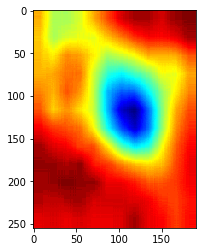

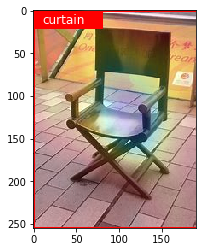

In [0]:
import cv2
import matplotlib.patches as patches
from tensorflow.keras.preprocessing import image

# define Model
pred_list=[]
pred_list, output_image, yy, xx, h, w = buildCAM_mul(3, img_path, 1, 0.2)
pred_cls = class_name[np.argsort(pred_list)[-3]]
print(pred_cls)
fig, ax = plt.subplots(1)
rect = patches.Rectangle((xx, yy), w, h, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

rect_txt = patches.Rectangle((xx,yy), 80, 20, edgecolor='r', facecolor='r')
ax.add_patch(rect)
ax.add_patch(rect_txt)
ax.text(xx+10, yy+15, 
         '{}'.format(pred_cls),
         fontsize=12, color='w')
ax.imshow(output_image)